In [1]:
#imports
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from math import sqrt
from hyperopt import hp
from hyperopt.pyll import scope
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from catboost import CatBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from models.hyperopt_model import HyperoptModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr,  spearmanr,  kendalltau

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# read the data
preprocessed_data = pd.read_pickle('../data/preprocessed_twitter_quantitative.pd')

# Create a dataframe
df = pd.DataFrame(preprocessed_data)

In [3]:
# Create two new dataframes, one with the training rows, one with the test rows
train, test=train_test_split(df, test_size=0.2, random_state=0)

In [4]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 18680
Number of observations in the test data: 4670


Cross-validated scores: [ 0.81091475  0.8083243   0.78563884  0.70730121]
Average R^2 score: 0.778044775034


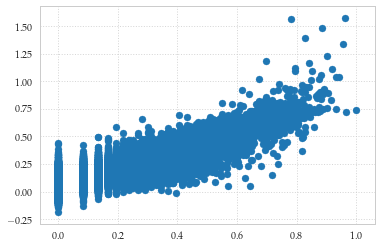

R2Score: 0.788965208874
RMSE: 0.09012235528663694


In [5]:
# Linear Regression 
dfLinear = df.copy()
y = dfLinear['score'].copy()
dfLinear.drop('score', axis=1, inplace=True) 

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(dfLinear, y, test_size=0.2)

model = linear_model.LinearRegression()

scores = cross_val_score(model, dfLinear, y, cv=4)
print("Cross-validated scores:", scores)
print("Average R^2 score:", scores.mean())

predictions = cross_val_predict(model, dfLinear, y, cv=4)
plt.scatter(y, predictions)
plt.show()

accuracy = metrics.r2_score(y, predictions)
print("R2Score:", accuracy)
rmse = sqrt(metrics.mean_squared_error(y,  predictions))
print("RMSE:", rmse)

In [6]:
    #some parameters
    DO_LOWESS = False
    hyperopt = False
    # Run Lasso Regression with hyperopt optimization
    lasso = HyperoptModel(train.copy(), test.copy(),'lasso', cv=4, max_evals = 500)
    features = list(df)
    features.remove('score')

    lasso.pipeline = Pipeline([
        ('estimate', linear_model.Lasso(**{'alpha': 0.0006577184991258585}))
    ])
    
    lasso.raw_features = features
    lasso.space = {
        'estimate__alpha': hp.uniform('estimate__alpha', 0, 10),
    }

    if hyperopt:
        lasso.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        lasso.pipeline.fit(X=lasso.X_train, y=lasso.y_train)
        lasso.model = lasso.pipeline
        lasso.stats()
        lasso.plot_feature_importance()
        lasso.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        lasso.qq_plot()

Stats (train | test):
	R^2 score:		0.7654
					0.7690
	RMSE:			0.0952
					0.0937
	Mean error:		0.0718
					0.0707
	Pearson:		0.8753
					0.8772
	Spearman:		0.8430
					0.8403
	KendallTau:		0.6830
					0.6826

Plotting predicted vs. actual ...done

Plotting QQ ...done



In [7]:
    #some parameters
    DO_LOWESS = False
    hyperopt = False
    # Run Ridge Regression with hyperopt optimization
    ridge = HyperoptModel(train.copy(), test.copy(),'ridge', cv=4, max_evals = 500)
    features = list(df)
    features.remove('score')
    ridge.raw_features = features

    ridge.pipeline = Pipeline([
        ('estimate', linear_model.Ridge(**{'alpha': 0.05231780585024858}))
    ])
    
    ridge.space = {
        'estimate__alpha': hp.uniform('estimate__alpha', 0, 1000),
    }

    if hyperopt:
        ridge.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        ridge.pipeline.fit(X=ridge.X_train, y=ridge.y_train)
        ridge.model = ridge.pipeline
        ridge.stats()
        ridge.plot_feature_importance()
        ridge.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        ridge.qq_plot()

Stats (train | test):
	R^2 score:		0.7964
					0.7972
	RMSE:			0.0887
					0.0878
	Mean error:		0.0669
					0.0659
	Pearson:		0.8924
					0.8929
	Spearman:		0.8523
					0.8477
	KendallTau:		0.6966
					0.6945

Plotting predicted vs. actual ...done

Plotting QQ ...done



In [8]:
    #some parameters
    DO_LOWESS = False
    hyperopt = True
    # Run MLPRegressor with hyperopt optimization
    nn = HyperoptModel(train.copy(), test.copy(),'nn', cv=3, max_evals=500)
    features = list(df)
    features.remove('score')
    nn.raw_features = features

    nn.pipeline = Pipeline([
        ('estimate', MLPRegressor())
    ])
   
    nn.space = {
         'estimate__alpha' : hp.uniform('estimate__alpha', 0.001, 1),
         'estimate__activation' : hp.choice('estimate__activation', ['logistic']), # 'identity', 'logistic', 'tanh', 'relu'
         #'estimate__learning_rate' : hp.choice('estimate__learning_rate', ['constant', 'invscaling', 'adaptive']),
         'estimate__hidden_layer_sizes' : scope.int(hp.uniform('estimate__hidden_layer_sizes', 1, 100)),
         'estimate__solver' : hp.choice('estimate__solver', ['adam']), #'lbfgs', 'sgd',
         #'estimate__max_iter' : scope.int(hp.uniform('estimate__max_iter', 500, 1000))
    }

    if hyperopt:
        nn.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        nn.pipeline.fit(X=nn.X_train, y=nn.y_train)
        nn.model = cat.pipeline
        nn.stats()
        nn.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        nn.plot_feature_importance()
        nn.qq_plot()

Performing parameters optimization...
[1/500]	cv_eval_time=17.82 sec	RMSE=0.121513	R^2=0.615197
[2/500]	cv_eval_time=16.68 sec	RMSE=0.115382	R^2=0.656195
[3/500]	cv_eval_time=19.73 sec	RMSE=0.121868	R^2=0.622822
[4/500]	cv_eval_time=15.39 sec	RMSE=0.113762	R^2=0.678171
[5/500]	cv_eval_time=19.02 sec	RMSE=0.105879	R^2=0.705251
[6/500]	cv_eval_time=18.70 sec	RMSE=0.113644	R^2=0.658947
[7/500]	cv_eval_time=14.46 sec	RMSE=0.117548	R^2=0.601544
[8/500]	cv_eval_time=18.45 sec	RMSE=0.112282	R^2=0.673587
[9/500]	cv_eval_time=20.52 sec	RMSE=0.098422	R^2=0.742892
[10/500]	cv_eval_time=22.93 sec	RMSE=0.102283	R^2=0.718286
[11/500]	cv_eval_time=15.79 sec	RMSE=0.122085	R^2=0.620327
[12/500]	cv_eval_time=16.99 sec	RMSE=0.112450	R^2=0.679649
[13/500]	cv_eval_time=19.99 sec	RMSE=0.096949	R^2=0.764390
[14/500]	cv_eval_time=14.14 sec	RMSE=0.098888	R^2=0.762512
[15/500]	cv_eval_time=18.30 sec	RMSE=0.112121	R^2=0.669205
[16/500]	cv_eval_time=22.34 sec	RMSE=0.105972	R^2=0.708384
[17/500]	cv_eval_time=14.36

[139/500]	cv_eval_time=21.81 sec	RMSE=0.097050	R^2=0.763696
[140/500]	cv_eval_time=21.29 sec	RMSE=0.101452	R^2=0.728864
[141/500]	cv_eval_time=18.90 sec	RMSE=0.107554	R^2=0.702976
[142/500]	cv_eval_time=18.26 sec	RMSE=0.118661	R^2=0.632109
[143/500]	cv_eval_time=22.72 sec	RMSE=0.112151	R^2=0.666340
[144/500]	cv_eval_time=15.62 sec	RMSE=0.119590	R^2=0.626282
[145/500]	cv_eval_time=22.55 sec	RMSE=0.104460	R^2=0.710837
[146/500]	cv_eval_time=23.43 sec	RMSE=0.096594	R^2=0.772208
[147/500]	cv_eval_time=23.85 sec	RMSE=0.097449	R^2=0.761223
[148/500]	cv_eval_time=21.91 sec	RMSE=0.095309	R^2=0.776986
[149/500]	cv_eval_time=23.40 sec	RMSE=0.098284	R^2=0.744798
[150/500]	cv_eval_time=23.13 sec	RMSE=0.096865	R^2=0.754022
[151/500]	cv_eval_time=18.11 sec	RMSE=0.096740	R^2=0.746959
[152/500]	cv_eval_time=26.43 sec	RMSE=0.100683	R^2=0.738676
[153/500]	cv_eval_time=22.89 sec	RMSE=0.103010	R^2=0.715880
[154/500]	cv_eval_time=24.09 sec	RMSE=0.096673	R^2=0.759472
[155/500]	cv_eval_time=21.37 sec	RMSE=0.

[276/500]	cv_eval_time=25.83 sec	RMSE=0.101189	R^2=0.722668
[277/500]	cv_eval_time=22.38 sec	RMSE=0.097518	R^2=0.780013
[278/500]	cv_eval_time=26.93 sec	RMSE=0.096861	R^2=0.747457
[279/500]	cv_eval_time=20.87 sec	RMSE=0.093434	R^2=0.769307
[280/500]	cv_eval_time=21.66 sec	RMSE=0.093201	R^2=0.779680
[281/500]	cv_eval_time=20.71 sec	RMSE=0.104676	R^2=0.717735
[282/500]	cv_eval_time=23.93 sec	RMSE=0.097526	R^2=0.746737
[283/500]	cv_eval_time=24.47 sec	RMSE=0.101052	R^2=0.737217
[284/500]	cv_eval_time=25.24 sec	RMSE=0.098706	R^2=0.746878
[285/500]	cv_eval_time=25.79 sec	RMSE=0.096159	R^2=0.743894
[286/500]	cv_eval_time=25.29 sec	RMSE=0.097707	R^2=0.746154
[287/500]	cv_eval_time=22.92 sec	RMSE=0.106284	R^2=0.709181
[288/500]	cv_eval_time=22.21 sec	RMSE=0.101005	R^2=0.735753
[289/500]	cv_eval_time=19.84 sec	RMSE=0.118794	R^2=0.629262
[290/500]	cv_eval_time=26.24 sec	RMSE=0.099851	R^2=0.739579
[291/500]	cv_eval_time=22.26 sec	RMSE=0.093687	R^2=0.774936
[292/500]	cv_eval_time=24.62 sec	RMSE=0.

[413/500]	cv_eval_time=38.29 sec	RMSE=0.093067	R^2=0.756857
[414/500]	cv_eval_time=44.85 sec	RMSE=0.098071	R^2=0.739686
[415/500]	cv_eval_time=39.30 sec	RMSE=0.093099	R^2=0.773323
[416/500]	cv_eval_time=46.02 sec	RMSE=0.097441	R^2=0.753079
[417/500]	cv_eval_time=59.93 sec	RMSE=0.098166	R^2=0.747691
[418/500]	cv_eval_time=40.75 sec	RMSE=0.094766	R^2=0.764945
[419/500]	cv_eval_time=43.16 sec	RMSE=0.101047	R^2=0.733995
[420/500]	cv_eval_time=41.46 sec	RMSE=0.094475	R^2=0.756208
[421/500]	cv_eval_time=43.06 sec	RMSE=0.098289	R^2=0.748021
[422/500]	cv_eval_time=53.33 sec	RMSE=0.095836	R^2=0.761756
[423/500]	cv_eval_time=46.01 sec	RMSE=0.096951	R^2=0.766058
[424/500]	cv_eval_time=53.92 sec	RMSE=0.101863	R^2=0.729179
[425/500]	cv_eval_time=49.62 sec	RMSE=0.099935	R^2=0.743281
[426/500]	cv_eval_time=35.83 sec	RMSE=0.094806	R^2=0.757355
[427/500]	cv_eval_time=45.07 sec	RMSE=0.098351	R^2=0.751235
[428/500]	cv_eval_time=56.39 sec	RMSE=0.093978	R^2=0.769040
[429/500]	cv_eval_time=64.29 sec	RMSE=0.

In [9]:
    #some parameters
    DO_LOWESS = False
    hyperopt = True
    # Run CatBoostRegressor with hyperopt optimization
    cat = HyperoptModel(train.copy(), test.copy(),'cat', cv=3, max_evals = 30)

    cat.pipeline = Pipeline([
        ('estimate', CatBoostRegressor())
    ])
    
    features = list(df)
    features.remove('score')
    cat.raw_features = features
    
    cat.space = {
        'estimate__iterations': hp.choice('estimate__iterations', [1300]),
        'estimate__loss_function': hp.choice('estimate__loss_function', ['RMSE']),
        'estimate__train_dir': hp.choice('estimate__train_dir', ['outputs/cat']),
        'estimate__thread_count': hp.choice('estimate__thread_count', [4]),
        'estimate__used_ram_limit': hp.choice('estimate__used_ram_limit', [1024 * 1024 * 1024 * 4]),  # 4gb
        'estimate__random_seed': hp.choice('estimate__random_seed', [0]),

        'estimate__learning_rate': hp.loguniform('estimate__learning_rate', -5, 0),
        'estimate__random_strength': hp.choice('estimate__random_strength', [1, 20]),
        'estimate__l2_leaf_reg': hp.loguniform('estimate__l2_leaf_reg', 0, np.log(10)),
        'estimate__bagging_temperature': hp.uniform('estimate__bagging_temperature', 0, 1),
    }

    """
    find the best number of trees (following https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning_trees-number-docpage/#parameter-tuning_trees-number)
    need to also substitute the CatBoostRegressor parameters with:
        ('estimate', CatBoostRegressor(iterations=10000, loss_function='RMSE', auto_stop_pval=1e-4, use_best_model=True, train_dir='outputs/cat_trees', verbose=True))
    """
    # num_trees_train, num_trees_eval = train_test_split(train, test_size=0.2, random_state=0)
    # X = num_trees_train[list(filter(lambda column: column in cat.raw_features, cat.train.columns))]
    # y = num_trees_train['score']
    #
    # eval_X = num_trees_eval[list(filter(lambda column: column in cat.raw_features, cat.train.columns))]
    # eval_X = cat.pipeline.named_steps['prepare_features'].fit_transform(eval_X)
    # eval_set = (eval_X, num_trees_eval['score'])
    #
    # cat.pipeline.fit(X=X, y=y, estimate__eval_set=eval_set)
    # cat.model = cat.pipeline
    # print(cat.model.named_steps['estimate'].get_params())
    # cat.model.named_steps['estimate'].save_model('tmp/cat.model'.encode('utf-8'))

    if hyperopt:
        cat.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        cat.pipeline.fit(X=cat.X_train, y=cat.y_train)
        cat.model = cat.pipeline
        cat.stats()
        cat.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        cat.plot_feature_importance()
        #cat.qq_plot()

Performing parameters optimization...
[1/30]	cv_eval_time=457.65 sec	RMSE=0.065560	R^2=0.888299
[2/30]	cv_eval_time=463.15 sec	RMSE=0.065000	R^2=0.888548
[3/30]	cv_eval_time=465.19 sec	RMSE=0.074218	R^2=0.859949
[4/30]	cv_eval_time=464.80 sec	RMSE=0.068495	R^2=0.876632
[5/30]	cv_eval_time=477.56 sec	RMSE=0.067523	R^2=0.881872
[6/30]	cv_eval_time=454.31 sec	RMSE=0.063937	R^2=0.893162
[7/30]	cv_eval_time=478.20 sec	RMSE=0.076274	R^2=0.847658
[8/30]	cv_eval_time=452.82 sec	RMSE=0.063768	R^2=0.895298
[9/30]	cv_eval_time=467.46 sec	RMSE=0.068889	R^2=0.876230
[10/30]	cv_eval_time=461.63 sec	RMSE=0.075126	R^2=0.855489
[11/30]	cv_eval_time=458.86 sec	RMSE=0.068161	R^2=0.879447
[12/30]	cv_eval_time=460.54 sec	RMSE=0.071528	R^2=0.868163
[13/30]	cv_eval_time=470.97 sec	RMSE=0.064463	R^2=0.892234
[14/30]	cv_eval_time=432.04 sec	RMSE=0.065227	R^2=0.889342
[15/30]	cv_eval_time=427.98 sec	RMSE=0.063901	R^2=0.895552
[16/30]	cv_eval_time=471.44 sec	RMSE=0.069682	R^2=0.874849
[17/30]	cv_eval_time=470.69

In [10]:
    #some parameters
    DO_LOWESS = False
    hyperopt = True
    # Run LGBMRegressor with hyperopt optimization
    lgbm = HyperoptModel(train.copy(), test.copy(), 'lgbm', cv=3, max_evals=50)
    lgbm.pipeline = Pipeline([
        ('estimate', lgb.LGBMRegressor())
    ])
    
    features = list(df)
    features.remove('score')
    lgbm.raw_features = features
   
    """ find number of trees """
    # num_trees_train, num_trees_eval = train_test_split(train, test_size=0.2, random_state=0)
    # X = num_trees_train[list(filter(lambda column: column in lgbm.raw_features, lgbm.train.columns))]
    # y = num_trees_train['score']
    #
    # eval_X = num_trees_eval[list(filter(lambda column: column in lgbm.raw_features, lgbm.train.columns))]
    # eval_X = lgbm.pipeline.named_steps['prepare_features'].fit_transform(eval_X)
    # eval_set = (eval_X, num_trees_eval['score'])
    #
    # best = lgbm.pipeline.fit(X=X, y=y, estimate__eval_set=eval_set, estimate__early_stopping_rounds=10)
    # print(best.named_steps['estimate'].best_iteration)

    lgbm.space = {
        'estimate__objective': hp.choice('estimate__objective', ['regression']),
        'estimate__n_estimators': hp.choice('estimate__n_estimators', [400]),
        'estimate__seed': hp.choice('estimate__seed', [0]),

        'estimate__learning_rate': hp.loguniform('estimate__learning_rate', -7, 0),
        'estimate__num_leaves': scope.int(hp.qloguniform('estimate__num_leaves', 1, 7, 1)),
        'estimate__feature_fraction': hp.uniform('estimate__feature_fraction', 0.5, 1),
        'estimate__bagging_fraction': hp.uniform('estimate__bagging_fraction', 0.5, 1),
        'estimate__min_data_in_leaf': scope.int(hp.qloguniform('estimate__min_data_in_leaf', 0, 6, 1)),
        'estimate__min_sum_hessian_in_leaf': hp.loguniform('estimate__min_sum_hessian_in_leaf', -16, 5),
        'estimate__lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('estimate__lambda_l1_positive', -16, 2)]),
        'estimate__lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('estimate__lambda_l2_positive', -16, 2)]),
    }

    if hyperopt:
        lgbm.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        lgbm.pipeline.fit(X=lgbm.X_train, y=lgbm.y_train)
        lgbm.model = lgbm.pipeline
        lgbm.stats()
        lgbm.plot_predicted_vs_actual()
        lgbm.plot_feature_importance()

Performing parameters optimization...
[1/50]	cv_eval_time=192.18 sec	RMSE=0.066618	R^2=0.884703
[2/50]	cv_eval_time=796.85 sec	RMSE=0.129967	R^2=0.562813
[3/50]	cv_eval_time=242.29 sec	RMSE=0.071188	R^2=0.867228
[4/50]	cv_eval_time=785.41 sec	RMSE=0.064941	R^2=0.891575
[5/50]	cv_eval_time=253.63 sec	RMSE=0.100553	R^2=0.737870
[6/50]	cv_eval_time=62.47 sec	RMSE=0.074622	R^2=0.855154
[7/50]	cv_eval_time=1136.21 sec	RMSE=0.064923	R^2=0.890298
[8/50]	cv_eval_time=449.79 sec	RMSE=0.099932	R^2=0.741930
[9/50]	cv_eval_time=190.42 sec	RMSE=0.079247	R^2=0.837506
[10/50]	cv_eval_time=146.52 sec	RMSE=0.078312	R^2=0.843273
[11/50]	cv_eval_time=637.59 sec	RMSE=0.063978	R^2=0.893580
[12/50]	cv_eval_time=965.85 sec	RMSE=0.069878	R^2=0.872409
[13/50]	cv_eval_time=115.73 sec	RMSE=0.134152	R^2=0.534124
[14/50]	cv_eval_time=45.71 sec	RMSE=0.116643	R^2=0.648171
[15/50]	cv_eval_time=190.38 sec	RMSE=0.067838	R^2=0.879027
[16/50]	cv_eval_time=89.20 sec	RMSE=0.088769	R^2=0.796253
[17/50]	cv_eval_time=90.85 se

In [4]:
    #Polynomial linear regression 
    degrees = 4
    for d in range(1, degrees+1):
            print("Degree: %s" % d)
            # Create the model, split the sets and fit it
            polynomial_features = PolynomialFeatures(
                degree=d, include_bias=False
            )
            linear_regression = linear_model.LinearRegression()
            model = Pipeline([
                ("polynomial_features", polynomial_features),
                ("linear_regression", linear_regression)
            ])
            dfPoly = df.copy()
            y = dfPoly['score'].copy()
            dfPoly.drop('score', axis=1, inplace=True) 

            # create training and testing vars
            X_train, X_test, y_train, y_test = train_test_split(dfPoly, y, test_size=0.2)

            model.fit(X_train, y_train)
            # Calculate the metrics
            train_prediction = model.predict(X_train)
            test_prediction = model.predict(X_test)
            
            print('Polynomial degree: {}'.format(d))
            print('Stats (train | test):')
            print('\tR^2 score:\t\t%.4f\n\t\t\t\t\t%.4f' % (r2_score(y_train, train_prediction),
                                                        r2_score(y_test, test_prediction)))
            print('\tRMSE:\t\t\t%.4f\n\t\t\t\t\t%.4f' % (mean_squared_error(y_train, train_prediction) ** 0.5,
                                                     mean_squared_error(y_test, test_prediction) ** 0.5))
            print('\tMean error:\t\t%.4f\n\t\t\t\t\t%.4f' % (mean_absolute_error(y_train, train_prediction),
                                                         mean_absolute_error(y_test, test_prediction)))
            print('\tPearson:\t\t%.4f\n\t\t\t\t\t%.4f' % (pearsonr(y_train, train_prediction)[0],
                                                         pearsonr(y_test, test_prediction)[0]))
            print('\tSpearman:\t\t%.4f\n\t\t\t\t\t%.4f' % (spearmanr(y_train, train_prediction)[0],
                                                         spearmanr(y_test, test_prediction)[0]))
            print('\tKendallTau:\t\t%.4f\n\t\t\t\t\t%.4f' % (kendalltau(y_train, train_prediction)[0],
                                                         kendalltau(y_test, test_prediction)[0]))

Degree: 1
Polynomial degree: 1
Stats (train | test):
	R^2 score:		0.7966
					0.7960
	RMSE:			0.0883
					0.0892
	Mean error:		0.0667
					0.0666
	Pearson:		0.8925
					0.8923
	Spearman:		0.8517
					0.8495
	KendallTau:		0.6963
					0.6953
Degree: 2
Polynomial degree: 2
Stats (train | test):
	R^2 score:		0.8510
					0.6889
	RMSE:			0.0758
					0.1092
	Mean error:		0.0546
					0.0590
	Pearson:		0.9225
					0.8472
	Spearman:		0.8727
					0.8707
	KendallTau:		0.7254
					0.7210
Degree: 3


MemoryError: 